In [1]:
import neuralnetwork
from neuralnetwork import FFNN 
from neuralnetwork import Sigmoid
from neuralnetwork import MSE
from neuralnetwork import Adam
from neuralnetwork import Activations
from neuralnetwork import Constant
from neuralnetwork import RMS_prop
import math
import autograd.numpy as np
import sys
import warnings
from autograd import grad, elementwise_grad
from random import random, seed
from copy import deepcopy, copy
from typing import Tuple, Callable
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
#Create Runge dataset

#Setting up the input to use on the neural network script imported, using Runges Function

#Importing packages
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

#Random seed to keep the results consistent 
np.random.seed(2030)

def Runge():
    n = 500
    x = np.linspace(-1,1,n).reshape(-1,1) #interval between -1 and 1 formatted to fit in shape with the neural network
    denominator = 1 + (25*x**2) 
    y = 1 / denominator #will not add noise right now
    return x, y  

x, y = Runge()

#Setting up the design matrix is not necessary since we are using the neural network 
#But we still need to do some scaling
Xtrain, Xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=42)
#Scale data 
Scaling = StandardScaler(with_std = True)
Scaling.fit(Xtrain)
Xtrain = Scaling.transform(Xtrain)
Xtest = Scaling.transform(Xtest)
ymin, ymax = ytrain.min(), ytrain.max()
ytrain = (ytrain - ymin) / (ymax - ymin)
ytest = (ytest - ymin) / (ymax - ymin)

In [3]:
#Create heatmaps to visualize results (With a bit of help from CHATGP to understand how to structure the pandas dataset using pivot)
results_learning_rates = []
for layers, label in [
    ((1,50,1), '1 Hidden Layer'),
    ((1,50,100,1), '2 Hidden Layers')
    ]:

    for lr in [0.01, 0.001, 0.0065, 0.0001]:
        optimizer = [
            Adam(eta=lr, rho = 0.9, rho2=0.999), #vals chosen based on Geeks for Geeks source on Adam optimization
            RMS_prop(eta=lr, rho = 0.9),
            Constant(eta = lr)
        ]

        for o in optimizer:
            nn = FFNN(
                nodes = layers,
                hidden_activation= Sigmoid(),
                output_activation= lambda x: x, 
                cost_func = MSE()
            )

            res = nn.fit(
                X = Xtrain, 
                t = ytrain,
                scheduler = o, 
                batches = 4, 
                epochs = 2000, 
                lam = 0.01
            )

            ypred = nn.predict(Xtest)
            test_error = np.mean(ytest - ypred)**2 #MSE
            results_learning_rates.append({
                'layers': label,
                'lr': lr,
                'optimizer': o.__class__.__name__,
                'test error': test_error,
                'train error': res['train_errors'][-1]
            })


Adam: Eta=0.01, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.104   RMS_prop: Eta=0.01, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0953   Constant: Eta=0.01, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0570 Adam: Eta=0.001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0657 RMS_prop: Eta=0.001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0505  Constant: Eta=0.001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0547 Adam: Eta=0.0065, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.105   RMS_prop: Eta=0.0065, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0959  Constant: Eta=0.0065, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0503 Adam: Eta=0.0001, Lambda=0.01
  [==========

In [4]:
def heatmap_lr_test(results, plotting_val):
    df_learning = pd.DataFrame(results)
    layer = df_learning['layers'].unique() #to avvoid duplicate labels
    fig, axes = plt.subplots(1,2, figsize = (12,5))

    for ax, l in zip(axes, layer):
        pivot_pre = df_learning[df_learning['layers'] == l]
    
        pivot = pivot_pre.pivot(index = 'optimizer', columns = 'lr', values = f'{plotting_val}')
        sns.heatmap(pivot, annot = True, cmap = 'rocket_r', fmt = '.6f', ax = ax, center = 0)
        ax.set_title(f'Test error for {l}')
        ax.set_xlabel(fr'Learning rates $\mu$')
        ax.set_ylabel('Optimizers')
    
    plt.tight_layout()
    plt.show()
    return pivot


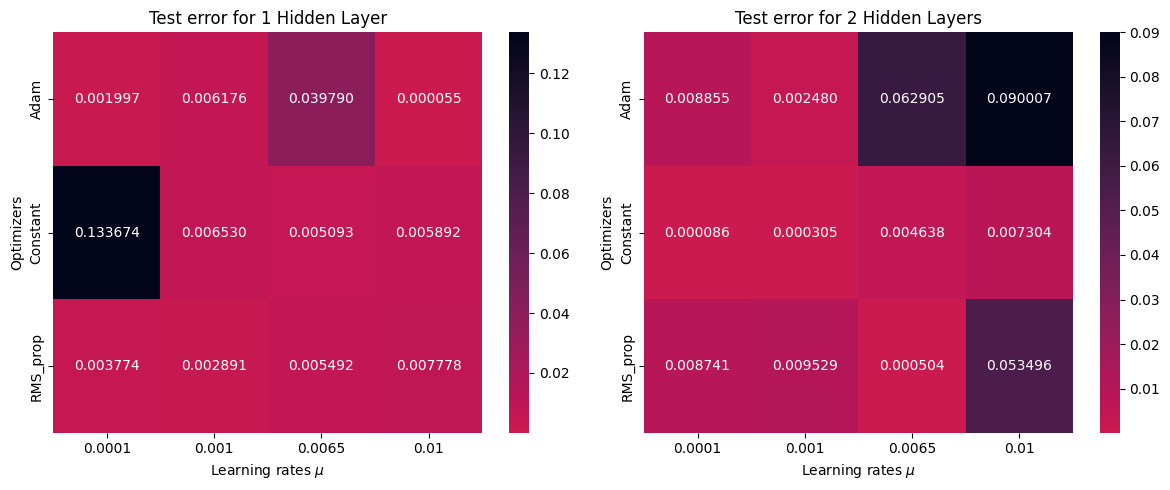

In [5]:
df_test = heatmap_lr_test(results_learning_rates, 'test error')

In [6]:
def heatmap_lr_train(results, plotting_val):
    df_learning = pd.DataFrame(results)
    layer = df_learning['layers'].unique() #to avvoid duplicate labels
    fig, axes = plt.subplots(1,2, figsize = (12,5))

    for ax, l in zip(axes, layer):
        pivot_pre = df_learning[df_learning['layers'] == l]
    
        pivot = pivot_pre.pivot(index = 'optimizer', columns = 'lr', values = f'{plotting_val}')
        sns.heatmap(pivot, annot = True, cmap = 'rocket_r', fmt = '.3f', ax = ax, center = 0)
        ax.set_title(f'Train error for {l}')
        ax.set_xlabel(fr'Learning rates $\mu$')
        ax.set_ylabel('Optimizers')
    
    plt.tight_layout()
    plt.show()
    return pivot

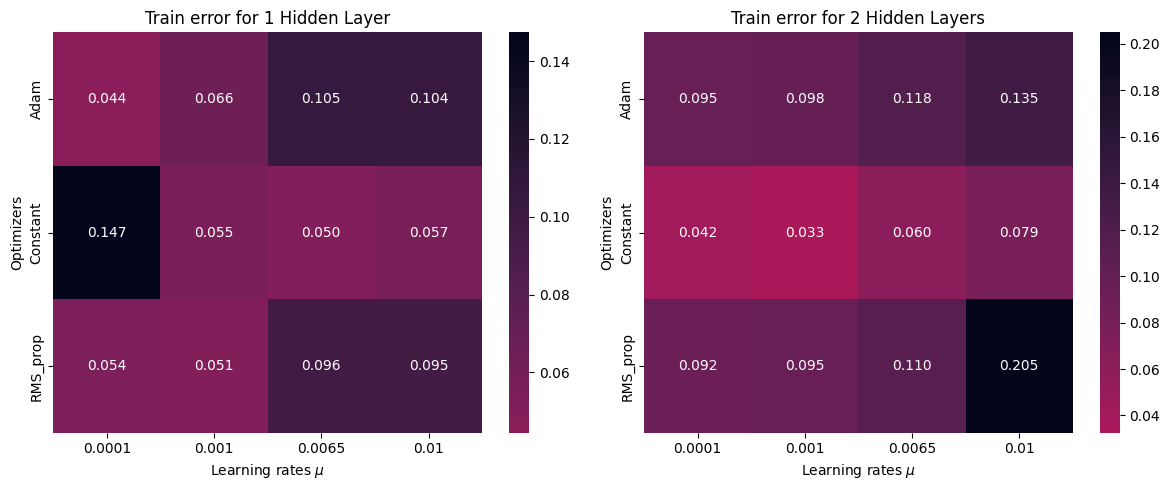

In [8]:
df_train = heatmap_lr_train(results_learning_rates, 'train error')

In [8]:
#Difference between train and test errors
df_test

lr,0.0001,0.0010,0.0065,0.0100
optimizer,,,,
Adam,0.008855,0.002480,0.062905,0.090007
Constant,0.000086,0.000305,0.004638,0.007304
RMS_prop,0.008741,0.009529,0.000504,0.053496


In [12]:
#seeing that lower learning rates clearly produces the best results, we can make a line plot to see how the scores improve with epochs
#Create heatmaps to visualize results (With a bit of help from CHATGP to understand how to structure the pandas dataset using pivot)
results_epochs = []
for layers, label in [
    ((1,50,1), '1 Hidden Layer'),
    ((1,50,100,1), '2 Hidden Layers')
    ]:

    for e in [10,100,1000,2000]:
        optimizer = [
            Adam(eta=0.0001, rho = 0.9, rho2=0.999), #vals chosen based on Geeks for Geeks source on Adam optimization
            RMS_prop(eta=0.0001, rho = 0.9),
            Constant(eta = 0.0001)
        ]

        for o in optimizer:
            nn = FFNN(
                nodes = layers,
                hidden_activation= Sigmoid(),
                output_activation= lambda x: x, 
                cost_func = MSE()
            )

            res = nn.fit(
                X = Xtrain, 
                t = ytrain,
                scheduler = o, 
                batches = 4, 
                epochs = e, 
                lam = 0.01
            )

            ypred = nn.predict(Xtest)
            test_error = np.mean(ytest - ypred)**2 #MSE
            results_epochs.append({
                'layers': label,
                'e': e,
                'optimizer': o.__class__.__name__,
                'test error': test_error,
                'train error': res['train_errors'][-1]
            })



Adam: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 2.28 RMS_prop: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 2.10 Constant: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 2.37 Adam: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 1.24 RMS_prop: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.355 Constant: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 2.20 Adam: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0469 RMS_prop: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0444 Constant: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.868 Adam: Eta=0.0001, Lambda=0.01
  [===================

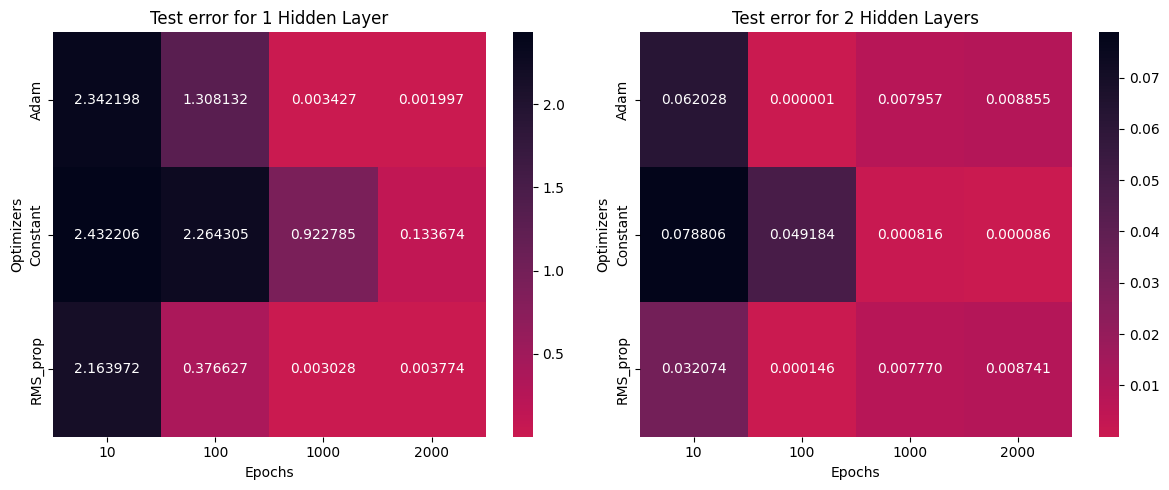

In [13]:
def heatmap_epoch_test(results, plotting_val):
    df_learning = pd.DataFrame(results)
    layer = df_learning['layers'].unique() #to avvoid duplicate labels
    fig, axes = plt.subplots(1,2, figsize = (12,5))

    for ax, l in zip(axes, layer):
        pivot_pre = df_learning[df_learning['layers'] == l]
    
        pivot = pivot_pre.pivot(index = 'optimizer', columns = 'e', values = f'{plotting_val}')
        sns.heatmap(pivot, annot = True, cmap = 'rocket_r', fmt = '.6f', ax = ax, center = 0)
        ax.set_title(f'Test error for {l}')
        ax.set_xlabel(fr'Epochs')
        ax.set_ylabel('Optimizers')
    
    plt.tight_layout()
    plt.show()
    return pivot

df_test_epoch = heatmap_epoch_test(results_epochs, 'test error')

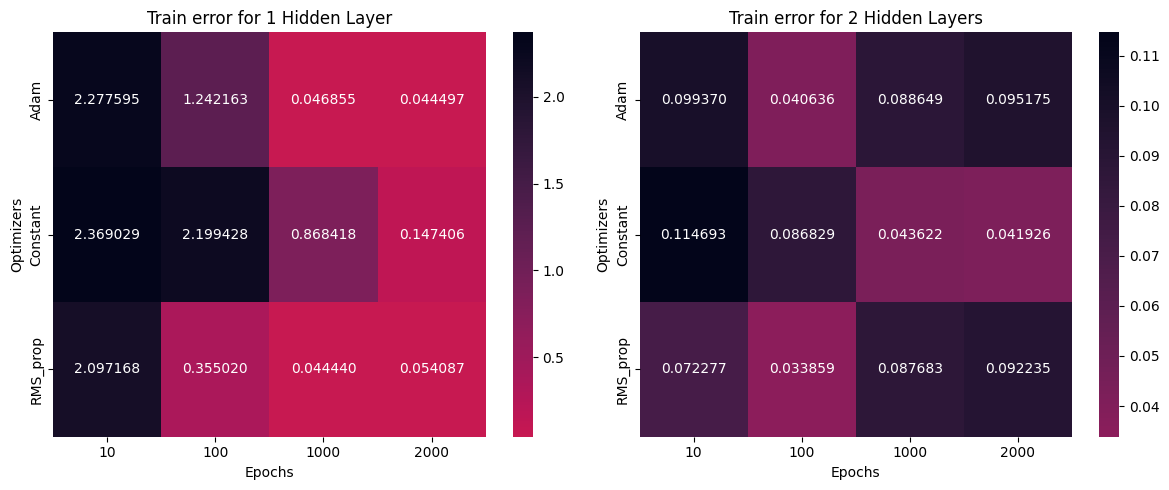

In [14]:
def heatmap_epoch_train(results, plotting_val):
    df_learning = pd.DataFrame(results)
    layer = df_learning['layers'].unique() #to avvoid duplicate labels
    fig, axes = plt.subplots(1,2, figsize = (12,5))

    for ax, l in zip(axes, layer):
        pivot_pre = df_learning[df_learning['layers'] == l]
    
        pivot = pivot_pre.pivot(index = 'optimizer', columns = 'e', values = f'{plotting_val}')
        sns.heatmap(pivot, annot = True, cmap = 'rocket_r', fmt = '.6f', ax = ax, center = 0)
        ax.set_title(f'Train error for {l}')
        ax.set_xlabel(fr'Epochs')
        ax.set_ylabel('Optimizers')
    
    plt.tight_layout()
    plt.show()
    return pivot

df_train_epoch = heatmap_epoch_train(results_epochs, 'train error')

In [15]:
#seeing that lower learning rates clearly produces the best results, we can make a line plot to see how the scores improve with epochs
#Create heatmaps to visualize results (With a bit of help from CHATGP to understand how to structure the pandas dataset using pivot)
results_batches = []
for layers, label in [
    ((1,50,1), '1 Hidden Layer'),
    ((1,50,100,1), '2 Hidden Layers')
    ]:

    for b in [1,4,8,12]:
        optimizer = [
            Adam(eta=0.0001, rho = 0.9, rho2=0.999), #vals chosen based on Geeks for Geeks source on Adam optimization
            RMS_prop(eta=0.0001, rho = 0.9),
            Constant(eta = 0.0001)
        ]

        for o in optimizer:
            nn = FFNN(
                nodes = layers,
                hidden_activation= Sigmoid(),
                output_activation= lambda x: x, 
                cost_func = MSE()
            )

            res = nn.fit(
                X = Xtrain, 
                t = ytrain,
                scheduler = o, 
                batches = b, 
                epochs = 2000, 
                lam = 0.01
            )

            ypred = nn.predict(Xtest)
            test_error = np.mean(ytest - ypred)**2 #MSE
            results_batches.append({
                'layers': label,
                'batch': b,
                'optimizer': o.__class__.__name__,
                'test error': test_error,
                'train error': res['train_errors'][-1]
            })


Adam: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0521 RMS_prop: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0473 Constant: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 1.53   Adam: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0445 RMS_prop: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0541 Constant: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.147  Adam: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0413 RMS_prop: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0457 Constant: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0692 Adam: Eta=0.0001, Lambda=0.01
  [=======

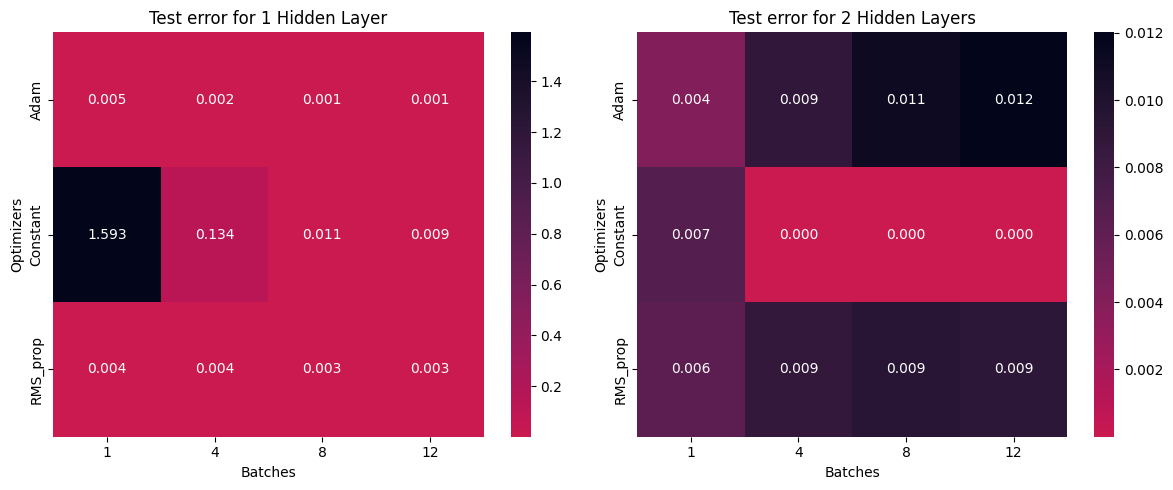

In [16]:
def heatmap_batches_test(results, plotting_val):
    df_learning = pd.DataFrame(results)
    layer = df_learning['layers'].unique() #to avvoid duplicate labels
    fig, axes = plt.subplots(1,2, figsize = (12,5))

    for ax, l in zip(axes, layer):
        pivot_pre = df_learning[df_learning['layers'] == l]
    
        pivot = pivot_pre.pivot(index = 'optimizer', columns = 'batch', values = f'{plotting_val}')
        sns.heatmap(pivot, annot = True, cmap = 'rocket_r', fmt = '.3f', ax = ax, center = 0)
        ax.set_title(f'Test error for {l}')
        ax.set_xlabel(fr'Batches')
        ax.set_ylabel('Optimizers')
    
    plt.tight_layout()
    plt.show()
    return pivot

df_test_batch = heatmap_batches_test(results_batches, 'test error')

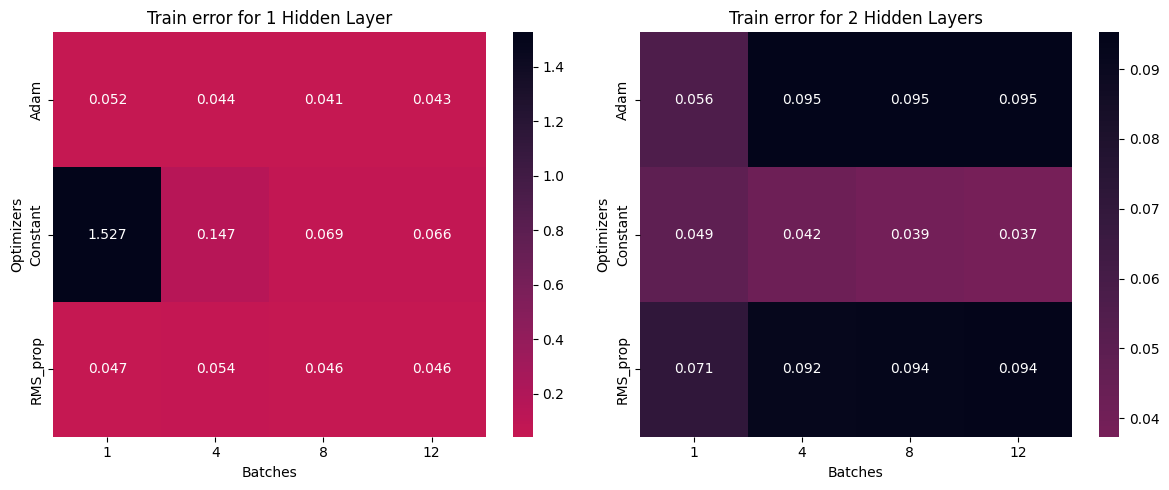

In [17]:
def heatmap_b_train(results, plotting_val):
    df_learning = pd.DataFrame(results)
    layer = df_learning['layers'].unique() #to avvoid duplicate labels
    fig, axes = plt.subplots(1,2, figsize = (12,5))

    for ax, l in zip(axes, layer):
        pivot_pre = df_learning[df_learning['layers'] == l]
    
        pivot = pivot_pre.pivot(index = 'optimizer', columns = 'batch', values = f'{plotting_val}')
        sns.heatmap(pivot, annot = True, cmap = 'rocket_r', fmt = '.3f', ax = ax, center = 0)
        ax.set_title(f'Train error for {l}')
        ax.set_xlabel(fr'Batches')
        ax.set_ylabel('Optimizers')
    
    plt.tight_layout()
    plt.show()
    return pivot

df_train_batch = heatmap_b_train(results_batches, 'train error')

In [18]:
#general func for plotting heatmaps - use for task D
def heatmap_gen(results, plotting_val, xlabel, title):
    df_learning = pd.DataFrame(results)
    layer = df_learning['layers'].unique() #to avvoid duplicate labels
    fig, axes = plt.subplots(1,2, figsize = (12,5))

    for ax, l in zip(axes, layer):
        pivot_pre = df_learning[df_learning['layers'] == l]
    
        pivot = pivot_pre.pivot(index = 'optimizer', columns = 'batch', values = f'{plotting_val}')
        sns.heatmap(pivot, annot = True, cmap = 'rocket_r', fmt = '.6f', ax = ax, center = 0)
        ax.set_title(f'{title}')
        ax.set_xlabel(fr'{xlabel}')
        ax.set_ylabel('Optimizers')
    
    plt.tight_layout()
    plt.show()
    return pivot

In [19]:
results_epochs_line = []
for layers, label in [
    ((1,50,1), '1 Hidden Layer'),
    ((1,50,100,1), '2 Hidden Layers')
    ]:

    for e in [500,1000,2000,3000,4000,5000,6000,7000, 8000,9000, 10000]:
        optimizer = [
            Adam(eta=0.0001, rho = 0.9, rho2=0.999), #vals chosen based on Geeks for Geeks source on Adam optimization
            RMS_prop(eta=0.0001, rho = 0.9),
            Constant(eta = 0.0001)
        ]

        for o in optimizer:
            nn = FFNN(
                nodes = layers,
                hidden_activation= Sigmoid(),
                output_activation= lambda x: x, 
                cost_func = MSE()
            )

            res = nn.fit(
                X = Xtrain, 
                t = ytrain,
                scheduler = o, 
                batches = 4, 
                epochs = e, 
                lam = 0.01
            )

            ypred = nn.predict(Xtest)
            test_error = np.mean(ytest - ypred)**2 #MSE but without 1/n to see how it evolves
            results_epochs_line.append({
                'layers': label,
                'epochs': e, 
                'optimizer': o.__class__.__name__,
                'Train error': res['train_errors'][-1],
                'Test Error' : test_error
            })


Adam: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0502 RMS_prop: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0476 Constant: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 1.53  Adam: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0469 RMS_prop: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0444 Constant: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.868 Adam: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0445 RMS_prop: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0541 Constant: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.147  Adam: Eta=0.0001, Lambda=0.01
  [=========

In [20]:
df_epochs = pd.DataFrame(results_epochs_line)

for l in df_epochs['layers'].unique():
    pivot_train = df_epochs[df_epochs['layers'] == l].pivot(index = 'epochs', columns = 'optimizer', values= 'Train error')
    pivot_test = df_epochs[df_epochs['layers'] == l].pivot(index = 'epochs', columns = 'optimizer', values= 'Test Error')
pivot_test

optimizer,Adam,Constant,RMS_prop
epochs,,,
500,0.003505,6.730485e-03,0.004287
1000,0.007957,8.158787e-04,0.007770
2000,0.008855,8.630396e-05,0.008741
3000,0.010241,3.779355e-05,0.009376
4000,0.011980,1.746239e-05,0.010692
5000,0.011872,5.597919e-06,0.011193
6000,0.009323,4.043205e-07,0.009897
7000,0.009538,1.037552e-06,0.009975
8000,0.007415,6.778266e-06,0.009360


In [21]:
pivot_train

optimizer,Adam,Constant,RMS_prop
epochs,,,
500,0.052438,0.048507,0.061628
1000,0.088649,0.043622,0.087683
2000,0.095175,0.041926,0.092235
3000,0.095199,0.040553,0.095191
4000,0.095286,0.039337,0.095209
5000,0.095277,0.038271,0.095231
6000,0.095211,0.037338,0.095199
7000,0.095204,0.036525,0.095198
8000,0.095394,0.035819,0.095210


In [23]:
""" Will probably be deleted"""
"""
def iterate(Optimizer, trainortest):
    mean_value = np.zeros(len(trainortest[Optimizer]))
    iter = 0 
    for i in x:
        mean_value[iter] = np.mean(trainortest[Optimizer][i])
        iter +=1
    return mean_value

Adam_mean_train = iterate(Optimizer='Adam', trainortest=pivot_train)
RMS_prop_mean_train = iterate(Optimizer='RMS_prop', trainortest=pivot_train)
Constant_mean_train = iterate(Optimizer='Constant', trainortest=pivot_train)

Adam_mean_test = iterate(Optimizer='Adam', trainortest=pivot_test)
RMS_prop_mean_test = iterate(Optimizer='RMS_prop', trainortest=pivot_test)
Constant_mean_test = iterate(Optimizer='Constant', trainortest=pivot_test)
"""

"\ndef iterate(Optimizer, trainortest):\n    mean_value = np.zeros(len(trainortest[Optimizer]))\n    iter = 0 \n    for i in x:\n        mean_value[iter] = np.mean(trainortest[Optimizer][i])\n        iter +=1\n    return mean_value\n\nAdam_mean_train = iterate(Optimizer='Adam', trainortest=pivot_train)\nRMS_prop_mean_train = iterate(Optimizer='RMS_prop', trainortest=pivot_train)\nConstant_mean_train = iterate(Optimizer='Constant', trainortest=pivot_train)\n\nAdam_mean_test = iterate(Optimizer='Adam', trainortest=pivot_test)\nRMS_prop_mean_test = iterate(Optimizer='RMS_prop', trainortest=pivot_test)\nConstant_mean_test = iterate(Optimizer='Constant', trainortest=pivot_test)\n"

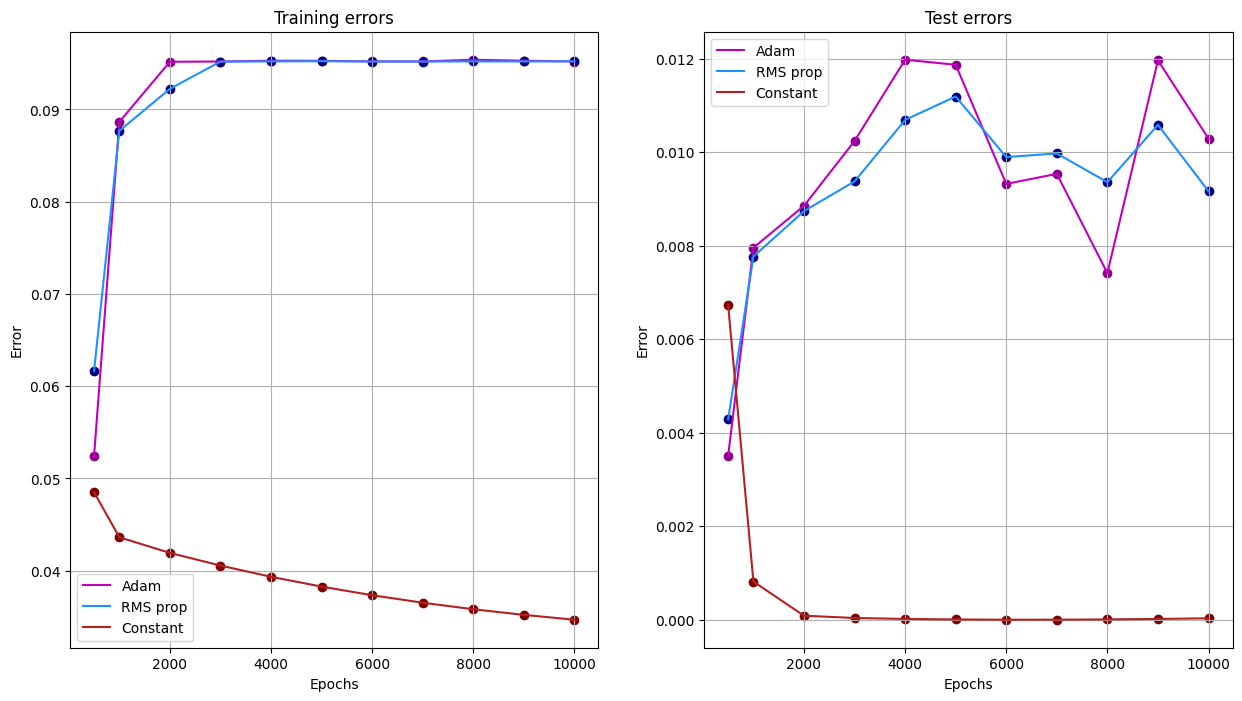

In [24]:
x = np.array([500,1000,2000,3000,4000,5000,6000,7000, 8000,9000, 10000]) 
fig, ax = plt.subplots(1,2, figsize = (15,8))
ax[0].plot(x, pivot_train.Adam, color = 'm', label = 'Adam')
ax[0].scatter(x, pivot_train.Adam, color = 'darkmagenta')
ax[0].plot(x, pivot_train.RMS_prop, color = 'dodgerblue', label = 'RMS prop')
ax[0].plot(x, pivot_train.Constant, color = 'firebrick', label = 'Constant')
ax[0].scatter(x, pivot_train.RMS_prop, color = 'navy')
ax[0].scatter(x, pivot_train.Constant, color = 'maroon')
ax[0].set_title('Training errors')
ax[1].plot(x, pivot_test.Adam, color = 'm', label = 'Adam')
ax[1].scatter(x, pivot_test.Adam, color = 'darkmagenta')
ax[1].plot(x, pivot_test.RMS_prop , color = 'dodgerblue', label = 'RMS prop')
ax[1].plot(x, pivot_test.Constant , color = 'firebrick', label = 'Constant')
ax[1].scatter(x, pivot_test.RMS_prop, color = 'navy')
ax[1].scatter(x, pivot_test.Constant , color = 'maroon')
ax[1].set_title('Test errors')
for axes in ax:
    axes.set_xlabel('Epochs')
    axes.set_ylabel('Error')
    axes.legend()
    axes.grid(True)
